# Sales Prediction Model Building Project

## Project Overview
This project aims to build a machine learning model to predict sales based on various factors including store characteristics, temporal features, promotions, and customer traffic.

### Dataset Information
- **Target Variable**: `sales` - Daily sales amount
- **Features**: Store ID, day of week, date, customer count, store status, promotions, holidays
- **Dataset Size**: ~640k records
- **Task Type**: Regression (predicting continuous sales values)

## 1. Project Setup and Data Loading

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [13]:
# Load the dataset
df = pd.read_csv('../data/sales.csv', index_col=0)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
df.head()

Dataset shape: (640840, 9)
Memory usage: 115.51 MB

First few rows:


,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
425390,366,4,2013-04-18,517,1,0,0,0,4422
291687,394,6,2015-04-11,694,1,0,0,0,8297
411278,807,4,2013-08-29,970,1,1,0,0,9729
664714,802,2,2013-05-28,473,1,1,0,0,6513
540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 640840 entries, 425390 to 305711
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   store_ID             640840 non-null  int64 
 1   day_of_week          640840 non-null  int64 
 2   date                 640840 non-null  object
 3   nb_customers_on_day  640840 non-null  int64 
 4   open                 640840 non-null  int64 
 5   promotion            640840 non-null  int64 
 6   state_holiday        640840 non-null  object
 7   school_holiday       640840 non-null  int64 
 8   sales                640840 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 48.9+ MB


In [15]:
df

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
425390,366,4,2013-04-18,517,1,0,0,0,4422
291687,394,6,2015-04-11,694,1,0,0,0,8297
411278,807,4,2013-08-29,970,1,1,0,0,9729
664714,802,2,2013-05-28,473,1,1,0,0,6513
540835,726,4,2013-10-10,1068,1,1,0,0,10882
...,...,...,...,...,...,...,...,...,...
359783,409,6,2013-10-26,483,1,0,0,0,4553
152315,97,1,2014-04-14,987,1,1,0,0,12307
117952,987,1,2014-07-07,925,1,0,0,0,6800
435829,1084,4,2014-06-12,725,1,0,0,0,5344


In [16]:
# in case the open is 0 show mean and sum of promotion, nb_costumers_on_day, sales
df.loc[df['open'] == 0].agg({'promotion': ['mean', 'sum'], 'nb_customers_on_day': ['mean', 'sum'], 'sales': ['mean', 'sum']})
# think about to set promotion and nb_customers_on_day to 0 when store is closed (open=0)

,promotion,nb_customers_on_day,sales
mean,0.064912,0.0,0.0
sum,7064.000000,0.0,0.0


In [17]:
# asign date column as datetime
df['date'] = pd.to_datetime(df['date'])
# asin the open, promotion and school_holiday columns as boolean
df['open'] = df['open'].astype(bool)
df['promotion'] = df['promotion'].astype(bool)
df['school_holiday'] = df['school_holiday'].astype(bool)



In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 640840 entries, 425390 to 305711
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   store_ID             640840 non-null  int64         
 1   day_of_week          640840 non-null  int64         
 2   date                 640840 non-null  datetime64[ns]
 3   nb_customers_on_day  640840 non-null  int64         
 4   open                 640840 non-null  bool          
 5   promotion            640840 non-null  bool          
 6   state_holiday        640840 non-null  object        
 7   school_holiday       640840 non-null  bool          
 8   sales                640840 non-null  int64         
dtypes: bool(3), datetime64[ns](1), int64(4), object(1)
memory usage: 36.1+ MB


count                           640840
mean     2014-04-11 02:05:13.957931008
min                2013-01-01 00:00:00
25%                2013-08-17 00:00:00
50%                2014-04-02 00:00:00
75%                2014-12-12 00:00:00
max                2015-07-31 00:00:00
Name: date, dtype: object


<Axes: >

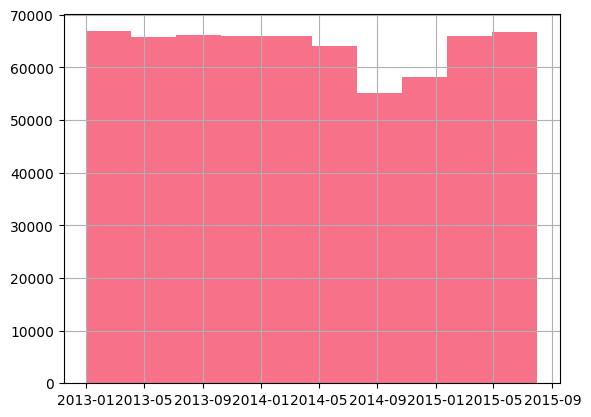

In [ ]:
print(df.date.describe())
# 
df.date.hist()


In [23]:
# lets check if we have missing date
df.date.max() - df.date.min()

Timedelta('941 days 00:00:00')

In [26]:
df.date.nunique()
# so no missing dates

942

In [29]:
df.describe()

,store_ID,day_of_week,date,nb_customers_on_day,sales
count,640840.000000,640840.000000,640840,640840.000000,640840.000000
mean,558.211348,4.000189,2014-04-11 02:05:13.957931008,633.398577,5777.469011
min,1.000000,1.000000,2013-01-01 00:00:00,0.000000,0.000000
25%,280.000000,2.000000,2013-08-17 00:00:00,405.000000,3731.000000
50%,558.000000,4.000000,2014-04-02 00:00:00,609.000000,5746.000000
75%,837.000000,6.000000,2014-12-12 00:00:00,838.000000,7860.000000
max,1115.000000,7.000000,2015-07-31 00:00:00,5458.000000,41551.000000
std,321.878521,1.996478,NaN,464.094416,3851.338083


In [28]:
for col in df.columns:
    print(f"{col}")
    print(f"{col}: {df[col].describe()}", "\n")

store_ID
store_ID: count    640840.000000
mean        558.211348
std         321.878521
min           1.000000
25%         280.000000
50%         558.000000
75%         837.000000
max        1115.000000
Name: store_ID, dtype: float64 

day_of_week
day_of_week: count    640840.000000
mean          4.000189
std           1.996478
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max           7.000000
Name: day_of_week, dtype: float64 

date
date: count                           640840
mean     2014-04-11 02:05:13.957931008
min                2013-01-01 00:00:00
25%                2013-08-17 00:00:00
50%                2014-04-02 00:00:00
75%                2014-12-12 00:00:00
max                2015-07-31 00:00:00
Name: date, dtype: object 

nb_customers_on_day
nb_customers_on_day: count    640840.000000
mean        633.398577
std         464.094416
min           0.000000
25%         405.000000
50%         609.000000
75%         838.000000
max  

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
425390,366,4,2013-04-18,517,True,False,0,False,4422
291687,394,6,2015-04-11,694,True,False,0,False,8297
411278,807,4,2013-08-29,970,True,True,0,False,9729
664714,802,2,2013-05-28,473,True,True,0,False,6513
540835,726,4,2013-10-10,1068,True,True,0,False,10882
...,...,...,...,...,...,...,...,...,...
359783,409,6,2013-10-26,483,True,False,0,False,4553
152315,97,1,2014-04-14,987,True,True,0,False,12307
117952,987,1,2014-07-07,925,True,False,0,False,6800
435829,1084,4,2014-06-12,725,True,False,0,False,5344


In [31]:
# handle the state_holiday column
df.state_holiday.value_counts()

state_holiday
0    621160
a     12842
b      4214
c      2624
Name: count, dtype: int64

In [46]:
# show the relation between state_holiday and date
#sns.scatterplot(data=df, x='date', y='state_holiday')
# show the unique dates for each non-zero state_holiday
df[df.state_holiday == 'a'].date.value_counts().sort_index()
# a means back holiday is spain


date
2013-01-01    719
2013-01-06    193
2013-05-01    694
2013-05-09    682
2013-05-20    710
2013-05-30    500
2013-08-15    117
2013-10-03    705
2013-10-31    100
2013-11-01    361
2013-11-20     50
2014-01-01    712
2014-01-06    193
2014-05-01    720
2014-05-29    704
2014-06-09    699
2014-06-19    474
2014-10-03    595
2014-10-31    108
2014-11-01    262
2014-11-19     45
2015-01-01    694
2015-01-06    198
2015-05-01    709
2015-05-14    716
2015-05-25    715
2015-06-04    467
Name: count, dtype: int64

In [ ]:
df[df.state_holiday == 'b'].date.value_counts().sort_index()
# b is a easter holiday

date
2013-03-29    713
2013-04-01    720
2014-04-18    708
2014-04-21    708
2015-04-03    686
2015-04-06    679
Name: count, dtype: int64

In [ ]:
df[df.state_holiday == 'c'].date.value_counts().sort_index()
# c is Xmas

date
2013-12-25    727
2013-12-26    697
2014-12-25    590
2014-12-26    610
Name: count, dtype: int64

In [ ]:
## so we can say that those stores are in Catalonia, Spain!!!!

In [54]:
# look for patterns in state holdiy and open close
df[(df.state_holiday != '0') & ((df.open == 1))].state_holiday.value_counts()

state_holiday
a    429
b    102
c     48
Name: count, dtype: int64

In [57]:
# look for correlation between state_holiday and sales
df[df.open == True].groupby('state_holiday').sales.agg(['mean', 'sum', 'count', 'std'])

,mean,sum,count,std
state_holiday,,,,
0,6957.122912,3697272529,531437,3099.131024
a,8452.615385,3626172,429,5795.264550
b,10449.764706,1065876,102,8293.907237
c,9763.833333,468664,48,6239.577609


In [58]:
# reduce the state holiday to binary 0 and 1
df.state_holiday = df.state_holiday.apply(lambda x: False if x == '0' else True)

In [143]:
# take out he cases where open is false
df_o = df.copy().loc[df.open == True].drop('open', axis=1)

In [144]:
#show on each day of the week the mean, sum., std of sales and nb_customers_on_day
df_o.groupby('day_of_week').sales.agg(['mean', 'median', 'sum', 'count', 'std'])


,mean,median,sum,count,std
day_of_week,,,,,
1,8220.868914,7540.0,710735222,86455,3693.070443
2,7088.979370,6505.0,642240264,90597,3059.724367
3,6729.364949,6213.0,600804432,89281,2774.307717
4,6777.319017,6250.0,575319834,84889,2777.182341
5,7076.695289,6584.0,619762820,87578,2765.833897
6,5878.606295,5425.0,534382948,90903,2859.917181
7,8295.599222,6965.0,19187721,2313,6211.309372


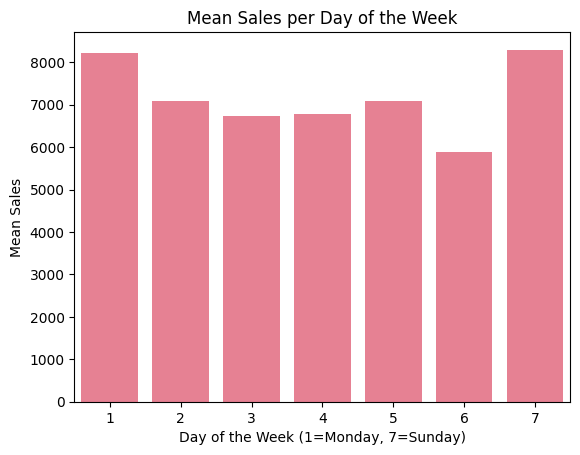

In [145]:
# plot the slales per day of the week
sns.barplot(data=df_o, x='day_of_week', y='sales', ci=None)
plt.title('Mean Sales per Day of the Week')
plt.xlabel('Day of the Week (1=Monday, 7=Sunday)')
plt.ylabel('Mean Sales')
plt.show()

In [146]:
df_o.groupby('day_of_week').nb_customers_on_day.agg(['mean', 'median', 'sum', 'count', 'std'])

,mean,median,sum,count,std
day_of_week,,,,,
1,855.177352,769.0,73934358,86455,418.868927
2,770.464905,685.0,69801809,90597,388.584776
3,740.310581,658.0,66095669,89281,369.875318
4,756.710375,673.0,64236387,84889,380.252557
5,781.396424,698.0,68433136,87578,382.069468
6,660.480479,573.0,60039657,90903,386.929568
7,1455.308258,1279.0,3366128,2313,1105.070463


In [147]:
# extract month and year from date
df_o['month'] = df_o.date.dt.month
df_o['year'] = df_o.date.dt.year

In [148]:
df_o.groupby('month').sales.agg(['mean', 'median', 'sum', 'count', 'std'])


,mean,median,sum,count,std
month,,,,,
1,6560.651142,6055.0,356807573,54386,2844.407253
2,6586.521900,6071.0,332784019,50525,2859.268427
3,6987.994996,6393.0,378441857,54156,3124.625664
4,7045.961529,6428.0,362084917,51389,3143.211595
5,7104.199193,6583.0,359110165,50549,3009.147039
6,7020.655030,6380.0,366225449,52164,3159.156890
7,6956.787439,6418.0,374936059,53895,3003.902943
8,6647.130927,6123.0,227650940,34248,2907.805738
9,6558.072343,6021.0,216206529,32968,2882.680226


In [149]:
df_o.groupby('year').sales.agg(['mean', 'median', 'sum', 'count', 'std'])


,mean,median,sum,count,std
year,,,,,
2013,6822.534180,6227.0,1452251448,212861,3116.513653
2014,7028.311754,6428.0,1375433582,195699,3132.010000
2015,7085.505856,6524.0,874748211,123456,3033.376328


In [150]:
# extract week of year from date
df_o['week_of_year'] = df_o.date.dt.isocalendar().week

In [151]:
df_o.groupby('week_of_year').sales.agg(['mean', 'median', 'sum', 'count', 'std'])


,mean,median,sum,count,std
week_of_year,,,,,
1,6219.545180,5732.0,59744951,9606,2846.719753
2,7657.960085,7189.0,94200567,12301,3160.381427
3,5975.418267,5503.5,75302221,12602,2593.068057
4,6516.252766,6050.0,81850651,12561,2740.720362
5,6350.665954,5847.0,80151755,12621,2711.110704
6,7607.097338,7133.0,95735320,12585,3112.077747
7,5679.087146,5301.0,71488349,12588,2351.987161
8,7236.370838,6779.0,91713764,12674,2949.848975
9,5853.527243,5368.0,74451013,12719,2466.617793


In [152]:
# so it seems like the month and thw week of the year is important as well as the day of the week but not the year
df_o.drop(['year'], axis=1, inplace=True)

In [153]:
df_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532016 entries, 425390 to 435829
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   store_ID             532016 non-null  int64         
 1   day_of_week          532016 non-null  int64         
 2   date                 532016 non-null  datetime64[ns]
 3   nb_customers_on_day  532016 non-null  int64         
 4   promotion            532016 non-null  bool          
 5   state_holiday        532016 non-null  bool          
 6   school_holiday       532016 non-null  bool          
 7   sales                532016 non-null  int64         
 8   month                532016 non-null  int32         
 9   week_of_year         532016 non-null  UInt32        
dtypes: UInt32(1), bool(3), datetime64[ns](1), int32(1), int64(4)
memory usage: 30.4 MB


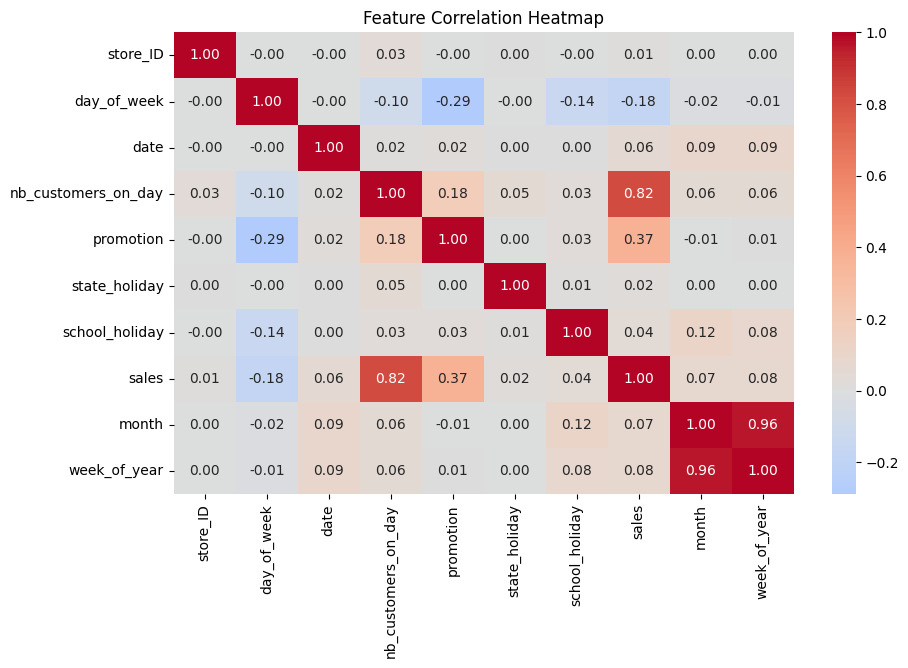

In [154]:
# do a heat map of the correlation between the features
plt.figure(figsize=(10, 6))
sns.heatmap(df_o.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

## 2. Exploratory Data Analysis (EDA)

=== CATEGORICAL VARIABLES ANALYSIS ===

DAY_OF_WEEK Value Counts:
day_of_week
1    86455
2    90597
3    89281
4    84889
5    87578
6    90903
7     2313
Name: count, dtype: int64

PROMOTION Value Counts:
promotion
False    294460
True     237556
Name: count, dtype: int64

STATE_HOLIDAY Value Counts:
state_holiday
False    531437
True        579
Name: count, dtype: int64

SCHOOL_HOLIDAY Value Counts:
school_holiday
False    429215
True     102801
Name: count, dtype: int64

MONTH Value Counts:
month
1     54386
2     50525
3     54156
4     51389
5     50549
6     52164
7     53895
8     34248
9     32968
10    33604
11    32395
12    31737
Name: count, dtype: int64

WEEK_OF_YEAR Value Counts:
week_of_year
1      9606
2     12301
3     12602
4     12561
5     12621
6     12585
7     12588
8     12674
9     12719
10    12527
11    12598
12    12710
13    12068
14    11295
15    11964
16    11971
17    11939
18    10625
19    11967
20    11965
21    12165
22    10906
23    12330
24    11

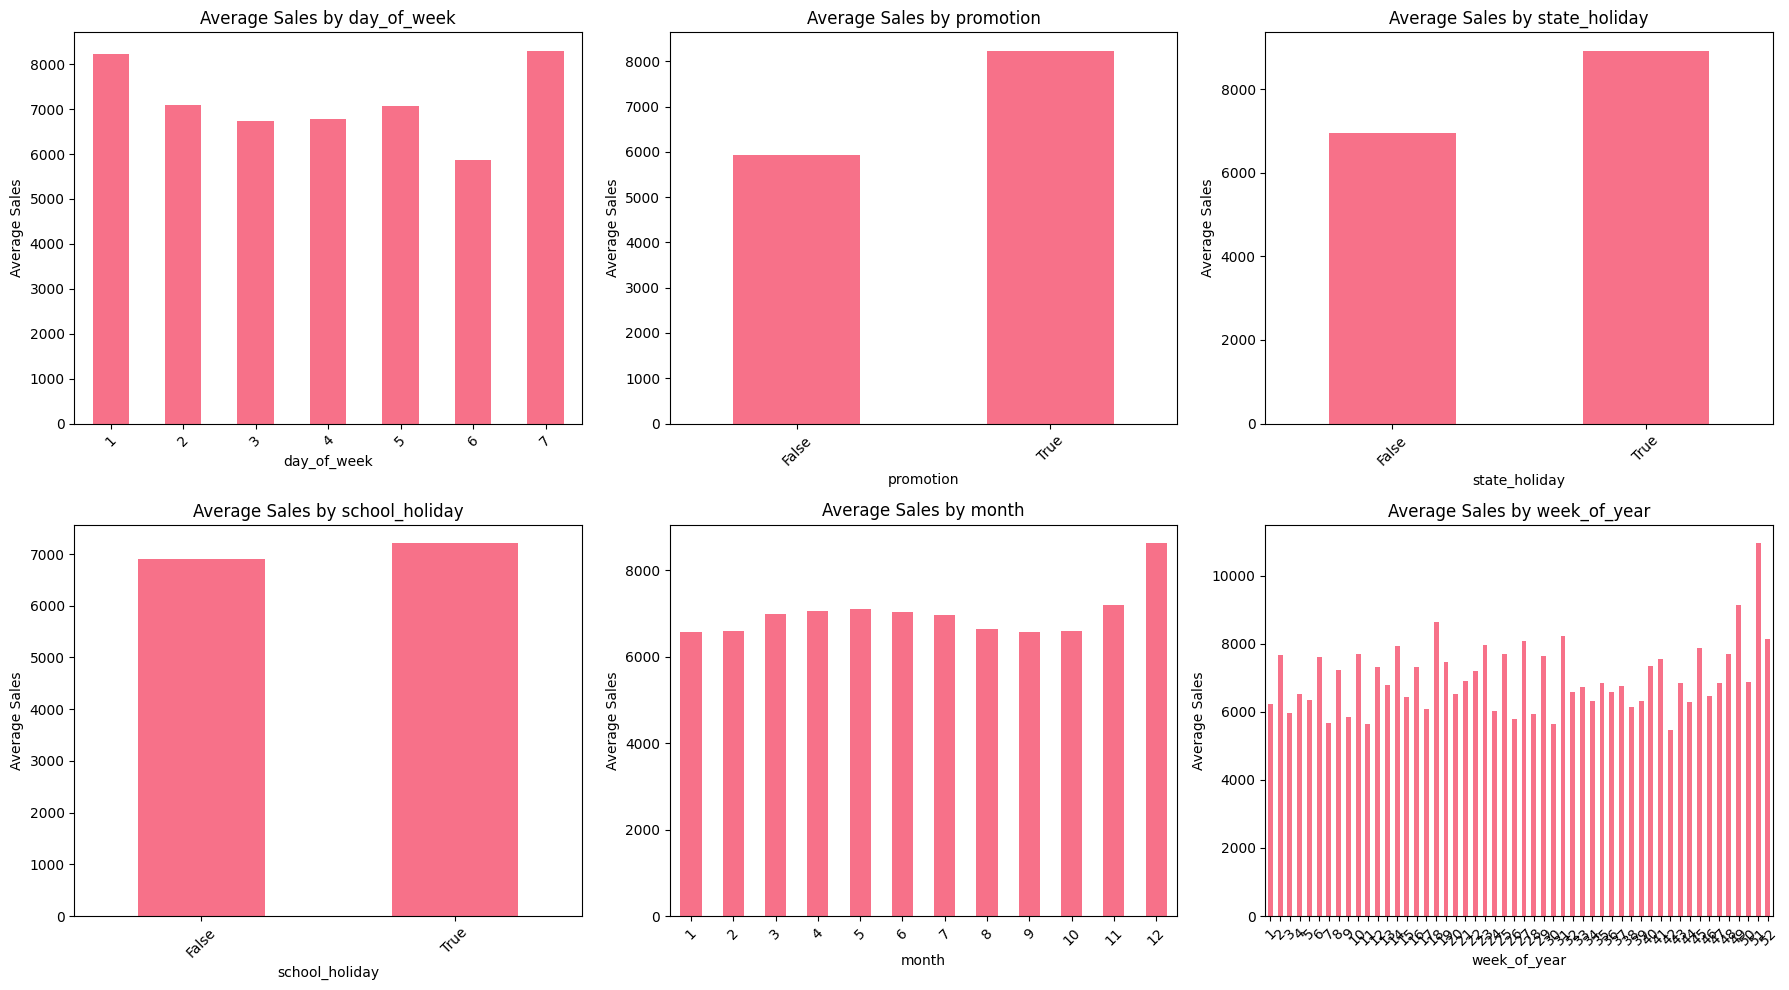

In [155]:
# Categorical variables analysis
print("=== CATEGORICAL VARIABLES ANALYSIS ===")
categorical_cols = ['day_of_week', 'promotion', 'state_holiday', 'school_holiday', 'month', 'week_of_year']

for col in categorical_cols:
    print(f"\n{col.upper()} Value Counts:")
    print(df_o[col].value_counts().sort_index())

# Visualize categorical variables vs sales
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if i < len(axes):
        df_o.groupby(col)['sales'].mean().plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Average Sales by {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Average Sales')
        axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplot
if len(categorical_cols) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [156]:
# exploring the sales and nb_customers_on_day relation to the store_id
df_st = df_o.copy().groupby('store_ID').agg({'sales': ['mean', 'median', 'std'], 'nb_customers_on_day': ['mean', 'median', 'std']}).reset_index()
# for the try we wont use the store_ID as feature

In [157]:
df_st.columns = ['store_ID', 'sales_mean', 'sales_median', 'sales_std', 'nb_customers_mean', 'nb_customers_median', 'nb_customers_std']
df_st

,store_ID,sales_mean,sales_median,sales_std,nb_customers_mean,nb_customers_median,nb_customers_std
0,1,4769.382643,4676.0,986.628549,564.493097,553.0,90.448364
1,2,4907.566929,4760.5,1645.602018,579.322835,574.0,157.861729
2,3,6886.496000,6671.0,2163.142677,746.586000,749.0,172.729469
3,4,9714.846639,9554.0,1938.199364,1327.577731,1310.5,198.194929
4,5,4650.859470,4597.0,1683.735543,537.340122,562.0,159.544532
...,...,...,...,...,...,...,...
1110,1111,5320.891837,5150.5,1581.267305,456.228571,460.5,111.088704
1111,1112,10143.727459,9421.0,3171.585445,831.645492,796.0,180.155589
1112,1113,6643.220202,6448.0,1406.900862,720.072727,708.0,120.948942
1113,1114,20481.172840,20200.0,3490.374584,3182.985597,3172.5,450.536672


In [158]:
df_st.nb_customers_median.describe()
print(df_o.nb_customers_on_day.quantile(0.75))

893.0


In [159]:
df_st['heavy_customer_store'] = df_st['nb_customers_median'] > 893

In [160]:
# so add a month is 12 or not 
df_o['is_december'] = df_o['month'] == 12

In [161]:
# show top 10 weeks of the year for sales
hight_sales_weeks = df_o.copy().groupby('week_of_year').sales.agg(['mean', 'median', 'sum', 'count', 'std']).sort_values(by='median', ascending=False).head(10).index.to_list()

In [162]:
df_o['high_sales_week'] = df_o['week_of_year'].isin(hight_sales_weeks)

In [163]:
# merge back to df_o
df_o = df_o.merge(df_st[['store_ID', 'heavy_customer_store']], on='store_ID', how='left')

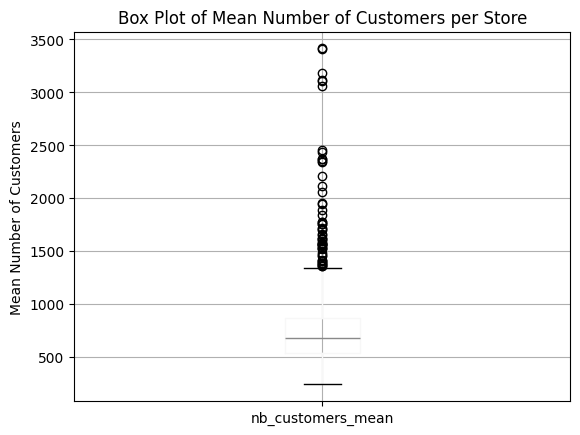

In [164]:
# no box plot nb_customers_mean
df_st.boxplot(column='nb_customers_mean')
plt.title('Box Plot of Mean Number of Customers per Store')
plt.ylabel('Mean Number of Customers')
plt.show()

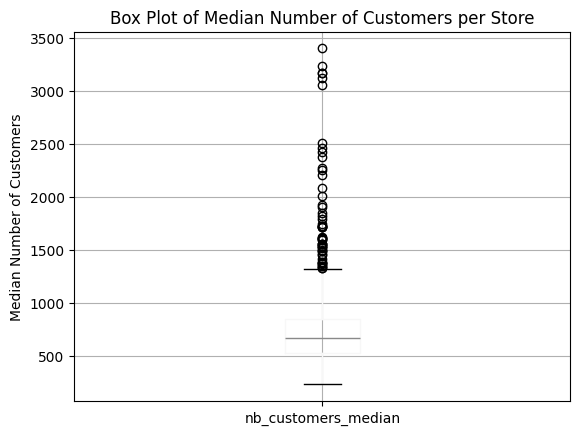

In [165]:
# now for the median
df_st.boxplot(column='nb_customers_median')
plt.title('Box Plot of Median Number of Customers per Store')
plt.ylabel('Median Number of Customers')
plt.show()

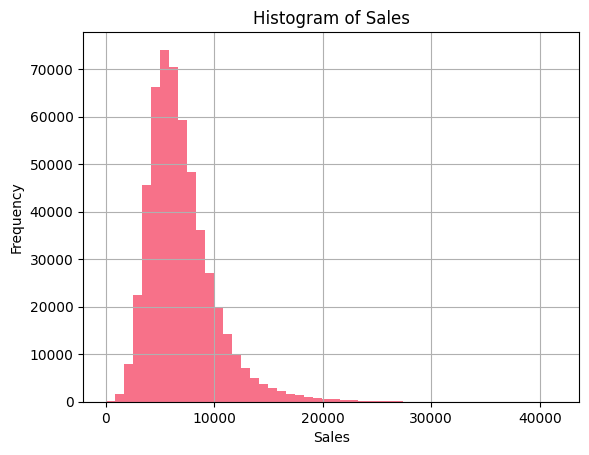

count    532016.000000
mean       6959.251679
std        3105.241710
min           0.000000
25%        4861.000000
50%        6372.000000
75%        8365.000000
max       41551.000000
Name: sales, dtype: float64
99th percentile: 17786.0


In [166]:
df_o.sales.hist(bins=50)
plt.title('Histogram of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()
print(df_o.sales.describe())
#print the the 99th percentile)
print(f"99th percentile: {df_o.sales.quantile(0.99)}")

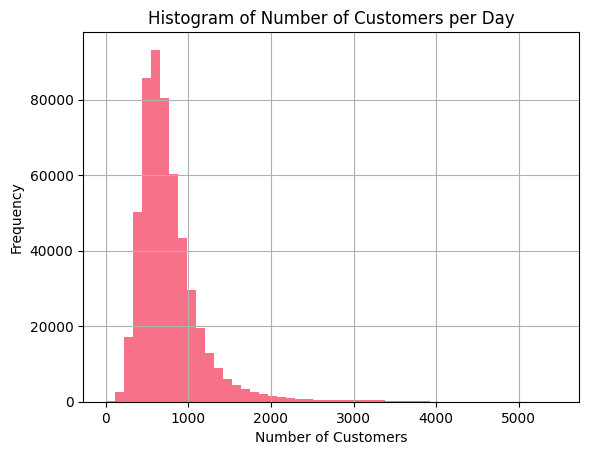

count    532016.000000
mean        762.960407
std         400.736508
min           0.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        5458.000000
Name: nb_customers_on_day, dtype: float64
99th percentile: 2414.0


In [167]:
df_o.nb_customers_on_day.hist(bins=50)
plt.title('Histogram of Number of Customers per Day')
plt.xlabel('Number of Customers')
plt.ylabel('Frequency')
plt.show()
print(df_o.nb_customers_on_day.describe())
#print the the 99th percentile)
print(f"99th percentile: {df_o.nb_customers_on_day.quantile(0.99)}")

In [168]:
# not going to do a an outliers cutting for now 

In [169]:
# log transform sales and nb_customers_on_day
df_o['log_sales'] = np.log1p(df_o['sales'])
df_o['log_nb_customers_on_day'] = np.log1p(df_o['nb_customers_on_day'])

In [170]:
df_o

,store_ID,day_of_week,date,nb_customers_on_day,promotion,state_holiday,school_holiday,sales,month,week_of_year,is_december,high_sales_week,heavy_customer_store,log_sales,log_nb_customers_on_day
0,366,4,2013-04-18,517,False,False,False,4422,4,16,False,False,False,8.394573,6.249975
1,394,6,2015-04-11,694,False,False,False,8297,4,15,False,False,False,9.023770,6.543912
2,807,4,2013-08-29,970,True,False,False,9729,8,35,False,False,True,9.182969,6.878326
3,802,2,2013-05-28,473,True,False,False,6513,5,22,False,False,False,8.781709,6.161207
4,726,4,2013-10-10,1068,True,False,False,10882,10,41,False,False,True,9.294957,6.974479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532011,77,6,2015-01-17,701,False,False,False,8219,1,3,False,False,False,9.014325,6.553933
532012,409,6,2013-10-26,483,False,False,False,4553,10,43,False,False,False,8.423761,6.182085
532013,97,1,2014-04-14,987,True,False,False,12307,4,16,False,False,False,9.418005,6.895683
532014,987,1,2014-07-07,925,False,False,False,6800,7,28,False,False,False,8.824825,6.830874


## 3. Data Preprocessing and Feature Engineering
#columns to target
sales
# columns to use a features


day_of_week

high_sales_week

is_december

log_nb_customers_on_day

promotion

state_holiday

school_holiday

heavy_customer_store






In [171]:
target = df_o['sales'].copy()
feature = df_o[['day_of_week', 'high_sales_week', 'heavy_customer_store', 'is_december', 'log_nb_customers_on_day', 'promotion', 'state_holiday', 'school_holiday', ]].copy()


## 3. Model Preparation and Training

In [128]:
# splint the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (425612, 8), y_train shape: (425612,)
X_test shape: (106404, 8), y_test shape: (106404,)


In [129]:
# Import machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor



In [ ]:
model = XGBRegressor(objective='reg:squarederror', random_state=42)
#from sklearn.ensemble import RandomForestRegressor
param_grid = {
    # versiom1 
    #'n_estimators': [100, 200, 300],
    #'learning_rate': [0.01, 0.1, 0.2],
    #'max_depth': [3, 5, 7]
    
    # winner 300, 0.1, 7
    'n_estimators': [600],
    'learning_rate': [0.01],
    'max_depth': [7],
    'min_child_weight': [3]
    #'gamma': [0],
    #'subsample': [0.8],
    #'colsample_bytree': [0.69],
    #'reg_alpha': [1.0],
    #'reg_lambda': [1],
}
grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=3, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated R2 score: ", grid_search.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=600; total time=   4.3s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=600; total time=   3.9s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=600; total time=   4.5s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=600; total time=   4.7s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=600; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=600; total time=   4.4s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=4, n_estimators=600; total time=   3.8s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=4, n_estimators=600; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=4, n_estimators=600; total time=   2.5s
Best parameters found:  {'learning_rate': 0.01, 'm

In [177]:
from sklearn import metrics
y_test_pred = grid_search.predict(X_test)
r2_test = metrics.r2_score(y_test, y_test_pred)
print(f"Test Set - R2 Score: {r2_test} on the test set")


Test Set - R2 Score: 0.7839301824569702 on the test set


In [178]:
best_model = grid_search.best_estimator_
importances = best_model.feature_importances_
feature_names = feature.columns

([<matplotlib.axis.XTick at 0x169baeb90>,
 [Text(0, 0, 'log_nb_customers_on_day'),
  Text(1, 0, 'promotion'),
  Text(2, 0, 'heavy_customer_store'),
  Text(3, 0, 'day_of_week'),
  Text(4, 0, 'is_december'),
  Text(5, 0, 'high_sales_week'),
  Text(6, 0, 'state_holiday'),
  Text(7, 0, 'school_holiday')])

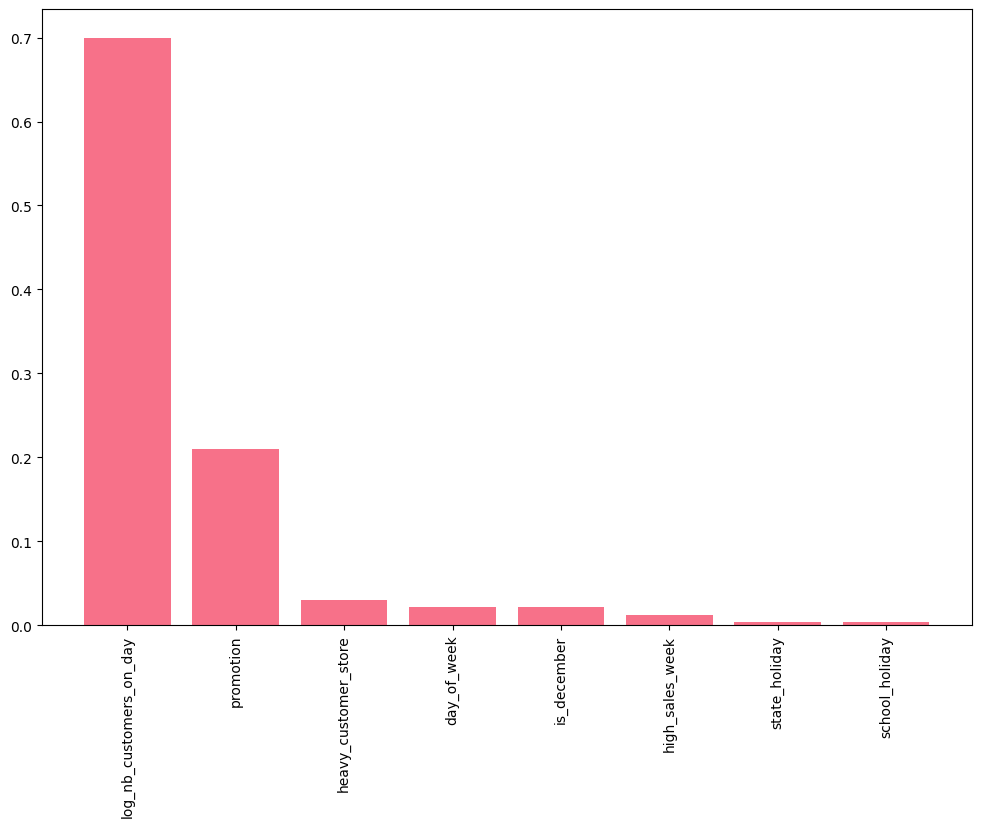

In [179]:
# plot the importances
plt.figure(figsize=(12,8))
indices = np.argsort(importances)[::-1]
plt.bar(range(feature.shape[1]), importances[indices], align='center')
plt.xticks(range(feature.shape[1]), feature_names[indices], rotation=90)

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 640840 entries, 425390 to 305711
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   store_ID             640840 non-null  int64         
 1   day_of_week          640840 non-null  int64         
 2   date                 640840 non-null  datetime64[ns]
 3   nb_customers_on_day  640840 non-null  int64         
 4   open                 640840 non-null  bool          
 5   promotion            640840 non-null  bool          
 6   state_holiday        640840 non-null  bool          
 7   school_holiday       640840 non-null  bool          
 8   sales                640840 non-null  int64         
dtypes: bool(4), datetime64[ns](1), int64(4)
memory usage: 31.8 MB


In [181]:
# now predict on the whole dataset
y_pred = grid_search.predict(feature)
df_o['predicted_sales'] = y_pred
# now left join on original df on store_ID and date
df_final = df.merge(df_o[['store_ID', 'date', 'predicted_sales']], on=['store_ID', 'date'], how='left')


In [182]:
# if preedicted sales is nan then set it to 0
df_final['predicted_sales'] = df_final['predicted_sales'].fillna(0)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   store_ID             640840 non-null  int64         
 1   day_of_week          640840 non-null  int64         
 2   date                 640840 non-null  datetime64[ns]
 3   nb_customers_on_day  640840 non-null  int64         
 4   open                 640840 non-null  bool          
 5   promotion            640840 non-null  bool          
 6   state_holiday        640840 non-null  bool          
 7   school_holiday       640840 non-null  bool          
 8   sales                640840 non-null  int64         
 9   predicted_sales      640840 non-null  float32       
dtypes: bool(4), datetime64[ns](1), float32(1), int64(4)
memory usage: 29.3 MB


In [183]:
# now recalculate the r2 on the whole dataset
from sklearn import metrics
y_final = df_final['sales']
y_final_pred = df_final['predicted_sales']
r2_final = metrics.r2_score(y_final, y_final_pred)
print(f"Final R2 Score on the whole dataset: {r2_final}")

Final R2 Score on the whole dataset: 0.8838716149330139


## 6. Model Optimization and Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning for best performing model
print("=== HYPERPARAMETER TUNING ===")

# Choose best model based on R² score
best_model_name = results_df['R²'].idxmax()
print(f"Best performing baseline model: {best_model_name}")

# Example: Hyperparameter tuning for Random Forest
if best_model_name == 'Random Forest':
    print("Tuning Random Forest hyperparameters...")
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Note: Use a smaller subset for faster tuning in practice
    rf_grid = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=3,  # 3-fold CV for faster execution
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Uncomment to run grid search (may take time)
    # rf_grid.fit(X_train, y_train)
    # print(f"Best parameters: {rf_grid.best_params_}")
    # print(f"Best CV score: {-rf_grid.best_score_:.2f}")
    
print("Hyperparameter tuning setup complete!")

## 7. Model Evaluation and Validation

In [ ]:
# Final model evaluation
print("=== FINAL MODEL EVALUATION ===")

# Train final model (use best model from comparison)
final_model = models[best_model_name]
final_model.fit(X_train, y_train)

# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Comprehensive evaluation
print(f"Final Model: {best_model_name}")
print("\nTraining Set Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"R²: {r2_score(y_train, y_pred_train):.4f}")

print("\nTest Set Performance:")
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"R²: {test_r2:.4f}")

# Residual analysis
residuals = y_test - y_pred_test

plt.figure(figsize=(15, 5))

# Residuals vs Predictions
plt.subplot(1, 3, 1)
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')

# QQ plot of residuals
from scipy import stats
plt.subplot(1, 3, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

# Actual vs Predicted
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')

plt.tight_layout()
plt.show()

In [ ]:
# Feature importance analysis
print("=== FEATURE IMPORTANCE ===")

if hasattr(final_model, 'feature_importances_'):
    # Get feature importances
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
else:
    print("Feature importance not available for this model type")